In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, get_scorer

In [2]:
df = pd.read_csv(r"..\..\oblig3_og_4\abalone.data", sep=",", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [13]:
df_targets = df['Rings']
features = df.drop('Rings', axis=1)
features['Sex'] = pd.Series(np.array(LabelEncoder().fit_transform(features['Sex'])))
df_features = pd.DataFrame(StandardScaler().fit_transform(features), columns=features.columns)

In [14]:
global_random_state = 15

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': get_scorer('r2'),
}  

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='r2', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

#### Beskrivelser av metoder for testing av datasettet
- For å test og tune modellene har jeg laget en custom nested CV funksjon som bruke GridSearchCV i scikit som den indre delen testningen. Ut av denne fuksjonen så får vi retunert den beste modellen for hver runde av den yttere delen av fuksjonen, de tilhørende scoring resultatene for både train og test oppsplitingen, og resultatene fra selve gridsearch modellen, som blandt annet kan brukes til å visualisere parameter tuningen.

- Som grunnleggende utgangspunkt kommer jeg til å bruke en oppsplitting på 5 deler for den yttere delen av nested cv fuksjonen og 4 deler for den indre delen av fuksjonen Dette gir en god balanse mellom trening og test data og sammen med nested CV fuksjonliteten gir dette et godt analyse grunnlag for å finne de beste modellene for datasettet Videre bruker det også et fast randomseed som er nødvedig for å sikre nested CV fuksjonaliteten brukere hele datasettet. 

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nytt for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter før den endelige kjøringen.

- Videre har jeg valgt å bruke  RandomForestRegressor, RidgeRegressor og LassoRegessor for å lage modeller til datasettet.

- For å vurdere disse modellene har jeg valgt å bruke disse metricene "mean absolutte error", "mean squared error" og "r2". r2 er et mål på hvor sterk korrelasjonen mellom de predikerte feature verdieen og target verdiere er. Mean absolute error er et mål på den absolutte feil mengde for prediksjonen til modellene, og gir en indikasjon på hvor mye feil prediksjonene er. mean squared error gir et bilde på hvor bra modellen håndere eventuelle uteligger feil, disse blir forsterket gjennom bergningen av feil margien.

In [15]:
rf_params = {
    'n_estimators': [100, 500],
    'max_depth': [6,8,12],
    'min_samples_leaf': [4,8,12],  
}

rf_estimators, rf_scores_train, rf_scores_test, rf_cv_results = train(df_features, df_targets,
    RandomForestRegressor(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_n_estimators', ylabel='mean_test_r2'>

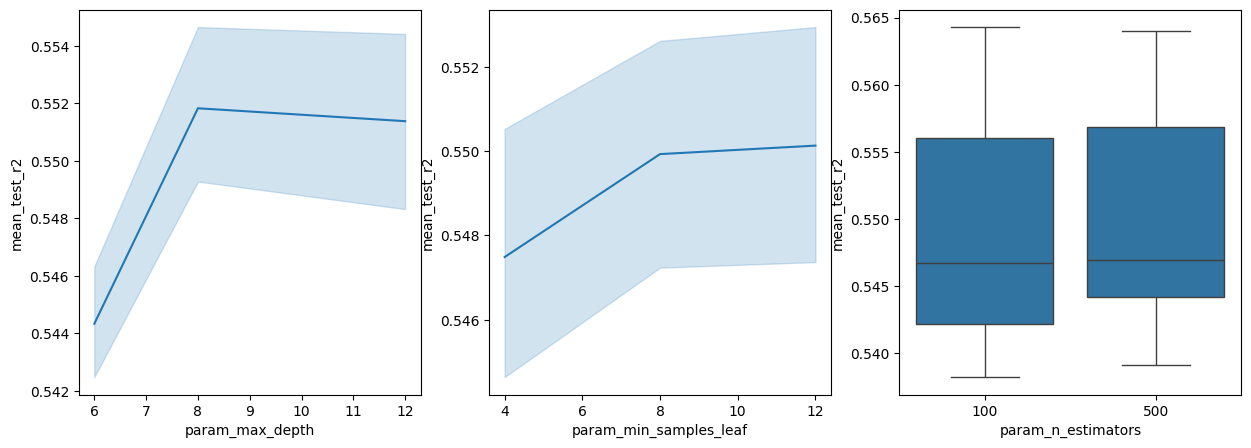

In [16]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=rf_cv_results, x='param_max_depth', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=rf_cv_results, x='param_min_samples_leaf', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=rf_cv_results, x='param_n_estimators', y='mean_test_r2', ax=ax[2])

In [192]:
rf_estimators

[RandomForestRegressor(max_depth=12, min_samples_leaf=8, n_estimators=500,
                       random_state=15),
 RandomForestRegressor(max_depth=12, min_samples_leaf=8, n_estimators=500,
                       random_state=15),
 RandomForestRegressor(max_depth=8, min_samples_leaf=12, n_estimators=500,
                       random_state=15),
 RandomForestRegressor(max_depth=12, min_samples_leaf=12, random_state=15),
 RandomForestRegressor(max_depth=8, min_samples_leaf=8, n_estimators=500,
                       random_state=15)]

In [17]:
rf_scores_test.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.503547,-4.587857,0.558750
std,0.017249,0.246402,0.015900
min,-1.531435,-4.962439,0.537620
25%,-1.507230,-4.661906,0.552398
50%,-1.498717,-4.511475,0.560337
75%,-1.493175,-4.506476,0.562038
max,-1.487177,-4.296990,0.581357


In [194]:
rf_scores_train.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.245437,-3.172299,0.694831
std,0.061761,0.308379,0.028725
min,-1.318413,-3.545610,0.659891
25%,-1.277708,-3.310916,0.682508
50%,-1.268382,-3.294138,0.682864
75%,-1.189934,-2.910820,0.720536
max,-1.172747,-2.800012,0.728356


#### RandomForestRegressor

- For å tune de avsluttende modellene for denne algoritmen så valgte jeg å bruke disse parameterne, max_depth, min_samples_leaf og n_estimatiors. Da jeg kom fram til at disse ga best uttelling. Utover parameterne og verdiene som er testet i den avsluttende modellen har jeg også prøve flere andre kombinasjoner uten at dette har gitt noen bedre resultater og pga. eksponential kjøretid har ikke tatt med disse i tresningen av de avsluttende modellene.

- Max_depth definere hvor dype de forskjellige trene i modellen kan være, generelt vil dette gjøre det at jo dypere treet er jo bedre kan disse tilpasse seg datasettet, men dette øker også risikoen for overfiting da du ofte kan få treer som tilpasser seg edge caser hvis du ikke implementere andre parameter for å unngå dette [1].

- min_samples_leaf er en parameter som brukes for å redusere overfiting på de forskjellige trærne, ved å sette en begrensing på minimums verdien en enkelt node i treet må innehold. Dvs. desto mindre denne verdien er desto mer risiko for overfiting vil du få, samt at modellen lettere tilpasser seg edge caser. Du kan også velge å erstatte denne parameteren med min_samples_split, da disse ofte gir relativt tilsvarende resultater. min_samples_split begrenser hvor mange verdier en node må ha for å kunne splittes opp i flere noder. Hoved forskjellen mellom disse parameterne er at min_samples_split vil være mer begrensede i forhold til veldig små edge caser ved bruk av høyere verdier for denne parameteren [1].

- n_estimator er en parameter som definere hvor mange individuelle treer modellen kan inneholde. Dvs. desto høyere denne verdien er jo bedre kan modellen tilpasse seg et datasett, men dette øker også risikoen for overfiting samt kjøretiden til modellen [1].

- For resultatene for denne algoritmen så er det modeller med max_dept = 8 og 12, min_samples_leaf= 8 og 12, og n_estimatiors på 500 som gir best resultat.
Hvis vi analysere disse i kontekst av plotene for tuning parameterne så er at det sannsynligvis ikke noen store forskjellig i prestasjon mellom disse "beste" modellene, men endringer av parameterne utover dette vil potensielt kunne påvirke prestasjonen til modellen betydelig.

- Når vi ser på resultatene for denne algoritmen så ser vi at det er en betydelig forskjell mellom test og training delen av datasettet noe som tyder på at modellen har en tendens til å overfite under trening. Videre ser vi at test resultatene gir oss en r2 korrelasjon på 0.56 som tyder på at modellen gir oss en moderat korrelasjon til å predikere target verdiene. Gjennomsnittet av Mean_absolute_error ligger på 1.50 og ut i fra en total range på 29 tyder dette på ganske lave feil-verdier for disse prediksjonene. Gjennomsnittet for mean_squared_error på 4.59 tyder også på at det heller ikke er mange store uteliggere i prediksjonene til modellene. Helhetlig tyder dette på at algoritmene klarer å levere en modell med relativt lav feil margin, men at selv korrelasjonen til modellene ikke er høy nok til å gi sterke prediksjoner.

ref[1]: Scikit Learn. (u.å) RandomForestRegressor. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [190]:
ridge_params = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000, 5000, 10000],
}

ridge_estimators, ridge_scores_train, ridge_scores_test, ridge_cv_results = train(df_features, df_targets,
    Ridge(random_state=global_random_state),
    ridge_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


<Axes: xlabel='param_max_iter', ylabel='mean_test_r2'>

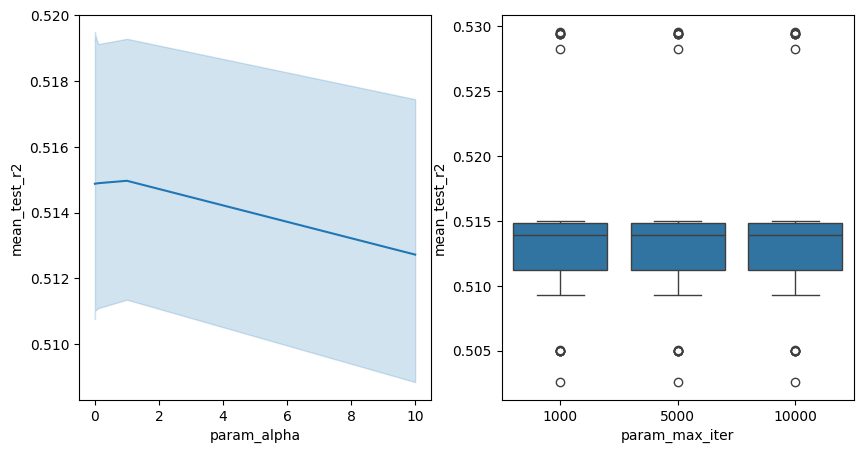

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=ridge_cv_results, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=ridge_cv_results, x='param_max_iter', y='mean_test_r2', ax=ax[1])

In [ ]:
ridge_scores_test.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.619724,-5.062067,0.511550
std,0.055328,0.404682,0.026838
min,-1.683125,-5.409673,0.481716
25%,-1.654492,-5.335722,0.492241
50%,-1.637316,-5.302409,0.505220
75%,-1.563683,-4.754574,0.534833
max,-1.560006,-4.507959,0.543738


In [ ]:
ridge_scores_train.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.606922,-4.892526,0.529143
std,0.018915,0.091232,0.006454
min,-1.629073,-5.012250,0.521689
25%,-1.625356,-4.951516,0.525547
50%,-1.596969,-4.886246,0.528052
75%,-1.595640,-4.823230,0.531805
max,-1.587574,-4.789386,0.538622


In [ ]:
ridge_estimators

[Ridge(alpha=1, max_iter=1000, random_state=15),
 Ridge(alpha=1, max_iter=1000, random_state=15),
 Ridge(alpha=1, max_iter=1000, random_state=15),
 Ridge(alpha=1, max_iter=1000, random_state=15),
 Ridge(alpha=0.1, max_iter=1000, random_state=15)]

#### Ridge Regression
- For denne type algoritme er det i utgangspunktet ikke en betydelig mengde med parametere som det er hensiktsmessig å tune, jeg har valg å bruke alpha, solver og max_iter for trening og tuning for denne algoritmen [2].

- Alpha parameteren er i utgangspunktet den viktigste parameteren for denne algoritemen og kontrollere regulariserings stryken til modellen gjennom multiplikasjon med L2 delen av uttrykket til linær regresjon, det er denne parameteren som gjør den algoritmen forskjellig fra standard linjer regresjon og Lasso regresjon som manipulere L1 delen av uttrykket til linjer regresjon [2].

- Solver parameteren definere forskjellige underliggende algoritmer som modellene bruker, disse har forskjellige fordeler og ulemper og gitt forskjellige karakteristikker for datasettet kan forskjelig av disse solverne gi bedre eller dårligere resultater [2].

- max_iter parameteren lar deg sette begrensninger på antall iterasjoner som modellen får kjøre, denne parameteren er i utgangspunktet kun relevant for noen av solver parameterne [2].

- For denne algoritmen så er det alpha=1 og max_iter=1000 som gir best resultater ved 4 av ytter loopene og på den siste ytter loopen så er det alpha=0.1 og max_iter=1000 som gir best resultat. For ytter loopene så er det deafault verdien ("auto") for solver som gir best resultat.  

- Når vi ser på resultatene for denne algoritmen så ser vi at det ikke er stor forskjeller mellom test og training delen av datasettet noe som tyder på at modellen ikke i betydelig grad overfiter ved trening av modellen på dette datasettet.Videre ser vi at test resultatene gir oss en r2 korrelasjon på 0.52 som tyder på at modellen gir oss en moderat korrelasjon til å predikere target verdiene. Med et gjennomsnitt for Mean_absolute_error ligger på 1.61 ut i fra en total range på 29 tyder dette på relativt lave feil-verdier for disse prediksjonene. Modellene gir et gjennomsnitt for mean_squared_error på 
5.01 tyder også på at det heller ikke er mange store uteliggere i prediksjonene til modellene. I likhet med RandomForest tyder dette på at algoritmene klarer å levere en modell med relativt lav feil margin, men at selv korrelasjonen til modellene ikke er høy nok til å gi sterke prediksjoner.

ref[2]: Scikit Learn. (u.å) Ridge. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [ ]:
lasso_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'tol': [0.0001,0.001,0.01,0.1],
    'max_iter': [1000, 5000, 10000],
}

lasso_estimators, lasso_scores_train, lasso_scores_test, lasso_cv_results = train(df_features, df_targets,
    Lasso(random_state=global_random_state),
    lasso_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_max_iter', ylabel='mean_test_r2'>

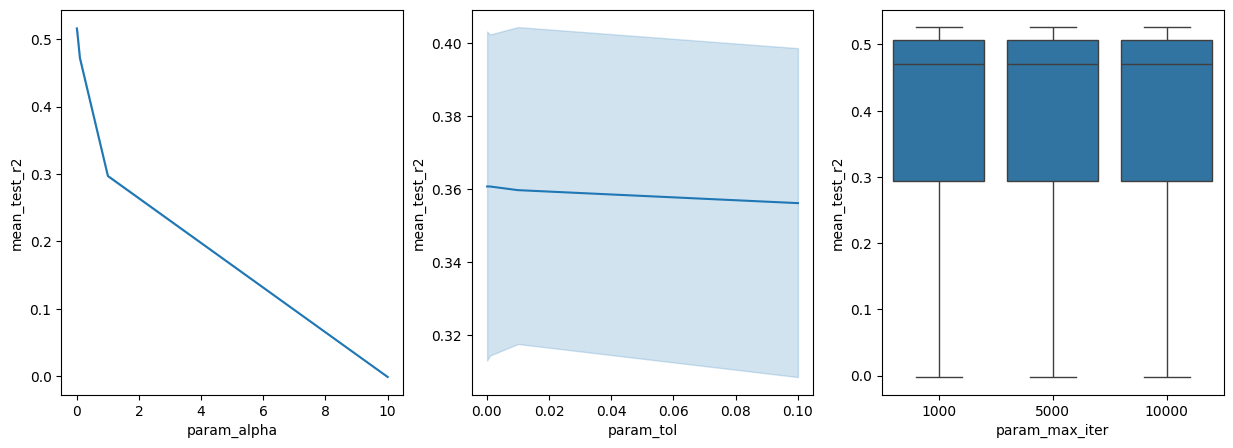

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=lasso_cv_results, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.lineplot(data=lasso_cv_results, x='param_tol', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=lasso_cv_results, x='param_max_iter', y='mean_test_r2', ax=ax[2])


In [ ]:
lasso_estimators

[Lasso(alpha=0.001, random_state=15),
 Lasso(alpha=0.001, random_state=15, tol=0.001),
 Lasso(alpha=0.001, random_state=15, tol=0.1),
 Lasso(alpha=0.001, random_state=15),
 Lasso(alpha=0.001, random_state=15)]

In [ ]:
lasso_scores_test.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.619690,-5.062456,0.511529
std,0.055490,0.405089,0.026523
min,-1.682961,-5.409686,0.481714
25%,-1.655462,-5.328771,0.492903
50%,-1.636716,-5.311416,0.505111
75%,-1.563584,-4.755623,0.534954
max,-1.559724,-4.506787,0.542963


In [ ]:
lasso_scores_train.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.607405,-4.897803,0.528724
std,0.011073,0.061599,0.005998
min,-1.625635,-4.995532,0.520385
25%,-1.609213,-4.908591,0.526720
50%,-1.603830,-4.878407,0.529149
75%,-1.600993,-4.877358,0.530443
max,-1.597356,-4.829127,0.536923


#### Lasso Regression
- For denne modellen har jeg valg å tune disse parameterne 'alpha', 'tol' og 'max_iter'.

- Akkurat som for RidgeRegressor så er alpha den viktigste parameteren du kan tune for denne algoritmen og det som gjør det forskjellig fra linjer regresjon og ridge regresjon [3].

- tol påvirker avslutnings kriteriet til modellen og desto lavere tol er jo lavere endringer kreves det for at modellen skal avslutte [3].

- max_iter setter en begrensning på det maksimale antallet iterasjoner modellen kan kjøre [3].

- For denne algoritmen så er det alpha=0.001 som gir best resultat, samt default max_iter (1000), for tol er det default (0.0001) som gir best resultat for 3 av ytter loopene og tol=0.1 og tol=0.001 gir best resultat for 1 ytter loop hver seg. Når vi ser på plotene for tuning parameterne så er det lite som tyder på at verdiene for 'tol' og 'max_iter' har veldig stor påvirkning på resultatene, mens vi ser at for alpha er det sannsynlig at denne vil påvirke mye.

- Når vi ser på resultatene for denne algoritmen så ser vi at det ikke er stor forskjeller mellom test og training delen av datasettet noe som tyder på at i likhet med rigde-modellene at modellene ikke i betydelig grad overfiter ved trening av modellene på dette datasettet. Videre ser vi at test resultatene gir oss en gjennomsnittlig r2 korrelasjon på 0.51 som tyder på at modellen gir oss en moderat korrelasjon til å predikere target verdiene. Videre for vi et gjennomsnitt for mean_absolute_error på 1.62, dette tyder på relativt lave feil-verdier for disse prediksjonene gitt total rangen til target verdiene. Modellene gir et gjennomsnitt for mean_squared_error på 5.01 som tyder på at modellen håndtere utliggere i test dataene relativt bra. I likhet med de andre modellene tyder dette på at algoritmen klarer å levere en modell med relativt lav feil margin, men at selv korrelasjonen til modellene ikke er høy nok til å gi gode prediksjonen for alder til abalonene.

ref [3]: Scikit Learn. (u.å) Lasso. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [206]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Mean absolute error:','Mean squared error:','r2:'],
    'RandomForest Train': [rf_scores_train["mean_absolute_error"].mean(), rf_scores_train["mean_squared_error"].mean(), rf_scores_train['r2'].mean()],
    'RandomForest Test': [rf_scores_test["mean_absolute_error"].mean(), rf_scores_test["mean_squared_error"].mean(), rf_scores_test['r2'].mean()],
    'Ridge Train': [ridge_scores_train["mean_absolute_error"].mean(), ridge_scores_train["mean_squared_error"].mean(), ridge_scores_train['r2'].mean()],
    'Ridge Test': [ridge_scores_test["mean_absolute_error"].mean(), ridge_scores_test["mean_squared_error"].mean(), ridge_scores_test['r2'].mean()],
    'Lasso Train': [lasso_scores_train["mean_absolute_error"].mean(), lasso_scores_train["mean_squared_error"].mean(), lasso_scores_train['r2'].mean()],
    'Lasso Test': [lasso_scores_test["mean_absolute_error"].mean(), lasso_scores_test["mean_squared_error"].mean(), lasso_scores_test['r2'].mean()],
})
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,RandomForest Train,RandomForest Test,Ridge Train,Ridge Test,Lasso Train,Lasso Test
Metric,,,,,,
Mean absolute error:,-1.245437,-1.503547,-1.607358,-1.614774,-1.607023,-1.619690
Mean squared error:,-3.172299,-4.587857,-4.897749,-5.012887,-4.892601,-5.062456
r2:,0.694831,0.558750,0.528729,0.517483,0.529136,0.511529


### Avsluttende vurdering
 - Ut i fra totalen av resultatene så ser det ut til at det er RandomForestRegressor som gir best resultater for dette datasettet med en avsluttene modell "RandomForestRegressor(max_depth=12, min_samples_leaf=8, n_estimators=500)" eller "RandomForestRegressor(max_depth=8, min_samples_leaf=12, n_estimators=500)". Ut i fra tuning plotene til modellene så ser det ikke ut som det vil være noe stor forskjell mellom disse to modellen.

 - Hvis vi ser på forskjellene for RandomForest kontra Ridge og Lasso så prestere RandomForest bedre for alle test metricene som er inkluderet, men det er ikke stor forskjeller i prestasjonene mellom disse algoritmene. Det imidlertid større forskjell mellom train og test resultatene for RandomForest enn det er for Ridge og Lasso, dette tyder på at RandomForest har større utfordringer med overfiting kontra de andre to algoritmene for dette datasettet. Det er også vært å nevne at RandomForest er betydelig mer tidkrevende å trene og tune på en god måte med nested CV, så ved videre bruk av denne typen modell vil det være viktig å kjøre en vurdering i forhold til tids bruk kontra prestasjon av modellen. 

 - Totaltsett tyder resultatene for dette datasettet på at det kan gi prediksjoner med relativt lav feilmargin når du ser mean absolute error opp mot toalt rangen av target verdier i datasettet, men at korrelasjonen mellom feature verdiene og target verdiene ikke er så sterk. Dette var forsåvitt også påpekt i kilden til datasete, og at det muligens var behov for mere data grunnlag som tar høyde for forskjellig miljø påvirkning for å bedre kunne estimere alder/ringer for adalonene [4].

 ref [4]: UC Irvine. (u.å) Abalone. Hentet 9. November 2025 fra https://archive.ics.uci.edu/dataset/1/abalone